In [1]:
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense , Activation
from tensorflow.keras.layers import Dropout , GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras.optimizers import Adam
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:

import cv2
import matplotlib.pyplot as plt
from time import time
from tensorflow.keras.preprocessing import image

from tensorflow.keras.layers import Input


In [3]:
TRAIN_DIR = "/home/anjali/Desktop/resp/b_cancer_data2/train"
VALID_DIR = "/home/anjali/Desktop/resp/b_cancer_data2/test"
IMG_SIZE = (299,299, 3)
BATCH_SIZE = 32

In [4]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 rotation_range=180,
                                 zoom_range=[1, 1.5], 
                                 width_shift_range=0.3,
                                 height_shift_range=0.3,
                                 shear_range=0.3,
                                 channel_shift_range=0) #included in our dependencies

test_datagen=ImageDataGenerator(rescale=1./255) #included in our dependencies


train_generator=train_datagen.flow_from_directory('/home/anjali/Desktop/resp/b_cancer_data2/train', # this is where you specify the path to the main data folder
                                                 target_size=(299,299),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)


test_generator=test_datagen.flow_from_directory('/home/anjali/Desktop/resp/b_cancer_data2/test', # this is where you specify the path to the main data folder
                                                 target_size=(299,299),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 6345 images belonging to 2 classes.
Found 1564 images belonging to 2 classes.


In [5]:
inception=InceptionV3(weights='imagenet',include_top=False,input_shape=(299, 299,3),input_tensor=None) #imports the mobilenet model and discards the last 1000 neuron layer.

x=inception.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
out=Dense(2,activation='softmax')(x) #final layer with softmax activation

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

complete_model = Model(inputs=inception.input, outputs=out)
es = EarlyStopping(patience=5)


In [7]:

complete_model.compile(loss='categorical_crossentropy',optimizer= 'adam',metrics=['accuracy'])
complete_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_v1[0][0]     
______________________________________________________________________________________________

In [8]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_test=test_generator.n//test_generator.batch_size

In [10]:
history=complete_model.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,
                                     validation_data=test_generator,validation_steps=step_size_test,callbacks=[es],epochs=15)


Epoch 1/15
198/198 [==============================] - 1489s 8s/step - loss: 0.6035 - accuracy: 0.7104 - val_loss: 0.4842 - val_accuracy: 0.5677
Epoch 2/15
198/198 [==============================] - 1444s 7s/step - loss: 0.4460 - accuracy: 0.8018 - val_loss: 0.7887 - val_accuracy: 0.5755
Epoch 3/15
198/198 [==============================] - 1444s 7s/step - loss: 0.3283 - accuracy: 0.8614 - val_loss: 1.0762 - val_accuracy: 0.7422
Epoch 4/15
198/198 [==============================] - 1467s 7s/step - loss: 0.2774 - accuracy: 0.8840 - val_loss: 0.7307 - val_accuracy: 0.8574
Epoch 5/15
198/198 [==============================] - 1455s 7s/step - loss: 0.2522 - accuracy: 0.8939 - val_loss: 4.5251 - val_accuracy: 0.6178
Epoch 6/15
198/198 [==============================] - 1452s 7s/step - loss: 0.2418 - accuracy: 0.9018 - val_loss: 0.4452 - val_accuracy: 0.7760
Epoch 7/15
198/198 [==============================] - 1450s 7s/step - loss: 0.2227 - accuracy: 0.9103 - val_loss: 1.6943 - val_accuracy:

In [11]:
#val accuracy
score  = complete_model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

49/49 [==============================] - 67s 1s/step - loss: 0.8088 - accuracy: 0.7916
Test loss: 0.8088329045140014
Test accuracy: 0.7915601


In [12]:
predgen = complete_model.predict_generator(test_generator, steps=len(test_generator), verbose=1) 
pred = np.argmax(predgen,axis = 1)
y_true=test_generator.classes

49/49 [==============================] - 69s 1s/step


In [13]:
y_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

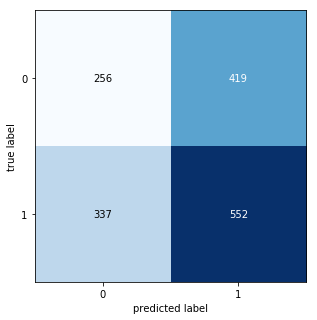

In [15]:
from sklearn.metrics import confusion_matrix
CM=confusion_matrix(y_true,pred)
from mlxtend.plotting import plot_confusion_matrix
fig,ax=plot_confusion_matrix(conf_mat=CM,figsize=(5,5))
plt.show()


In [16]:
tn,fp,fn,tp=CM.ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)

print("recall of the model is{:.2f}".format(recall))
print("precision of the model is {:.2f}".format(precision))

recall of the model is0.62
precision of the model is 0.57


In [22]:

layer_outputs = [layer.output for layer in complete_model.layers[:50]]
test_image = '/home/anjali/Desktop/resp/b_cancer_data2/test/MALIGNANT/SOB_M_DC-14-2523-40-010.png'

img = image.load_img(test_image, target_size=(299,299))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr /= 255.

In [23]:
activation_model = Model(inputs=complete_model.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

In [24]:
activations[1].shape

(1, 149, 149, 32)

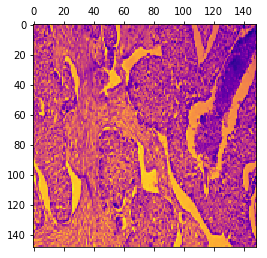

In [25]:
plt.matshow(activations[1][0, :, :, 1], cmap='plasma')
plt.show()

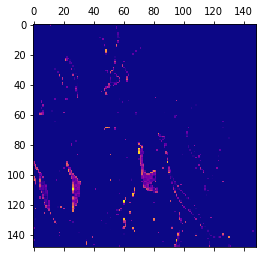

In [26]:
plt.matshow(activations[3][0, :, :, 1], cmap='plasma')
plt.show()

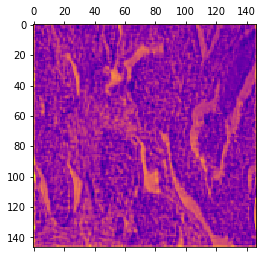

In [27]:


plt.matshow(activations[7][0, :, :, 1], cmap='plasma')
plt.show()



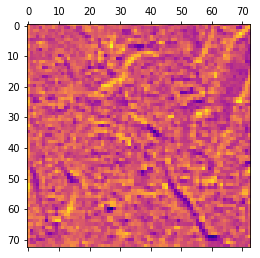

In [28]:

plt.matshow(activations[12][0, :, :, 5], cmap='plasma')
plt.show()



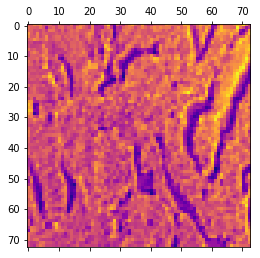

In [29]:


plt.matshow(activations[11][0, :, :, 20], cmap='plasma')
plt.show()



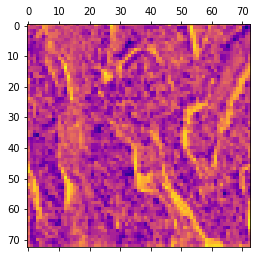

In [30]:


plt.matshow(activations[11][0, :, :, 79], cmap='plasma')
plt.show()



/home/anjali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


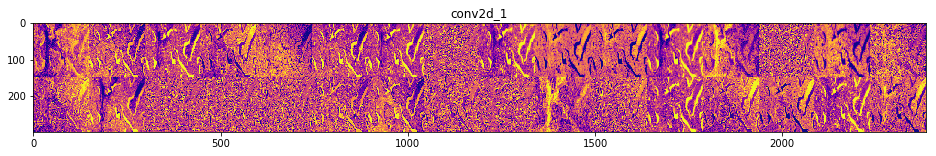

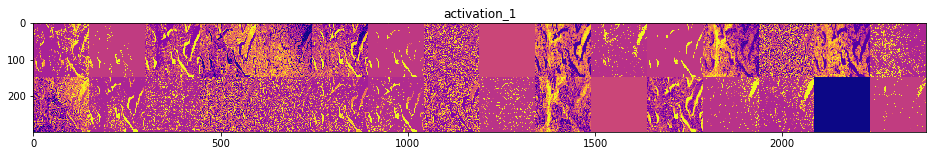

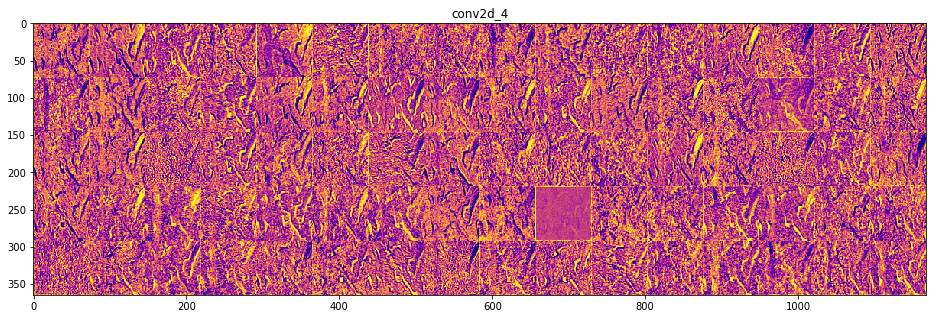

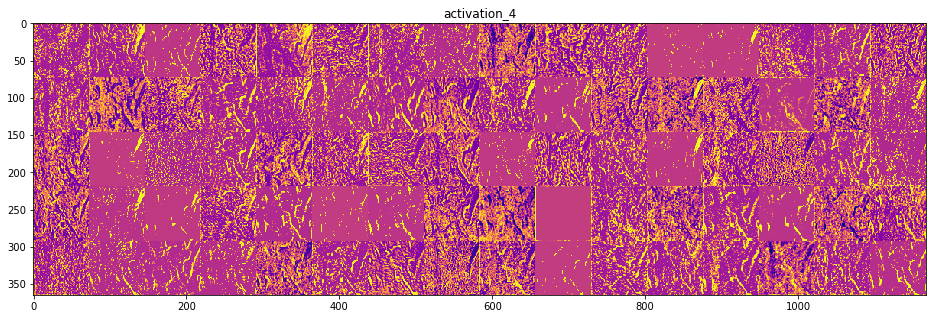

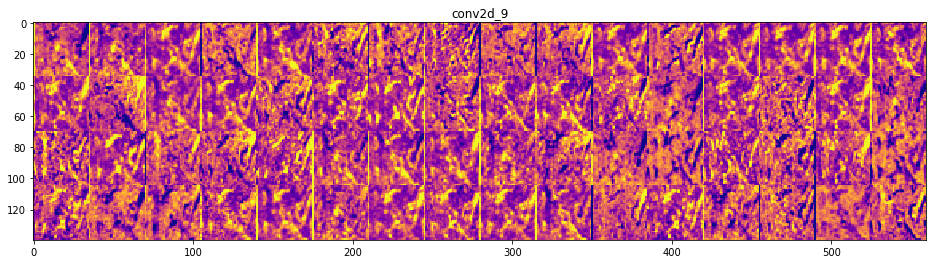

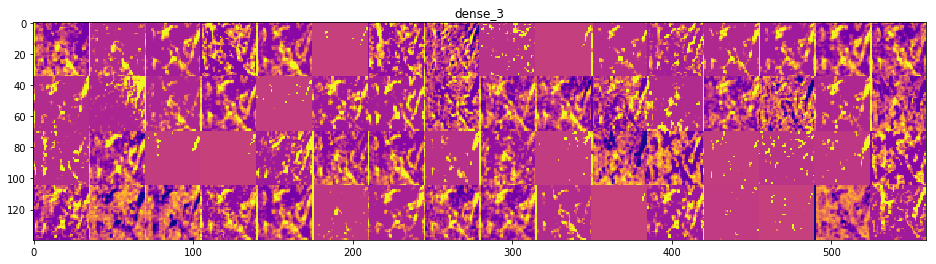

In [31]:
layer_names = ['conv2d_1', 'activation_1', 'conv2d_4', 'activation_4', 'conv2d_9', 'dense_3','activation_9']
activ_list = [activations[1], activations[3], activations[11], activations[13], activations[18], activations[20]]

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activ_list):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='plasma')
    plt.savefig(layer_name+"_grid.jpg", bbox_inches='tight')